# **Distilling Knowledge In Multiple Students Using GANs**

In [ ]:
# %tensorflow_version 1.x
# !pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
# import os
from tensorflow.keras.datasets import fashion_mnist,mnist,cifar10
# import keras.backend as K
from tensorflow.keras.layers import Conv2D,Activation,BatchNormalization,UpSampling2D,Embedding,ZeroPadding2D, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers

from tensorflow.keras.utils import Progbar
from keras.initializers import RandomNormal
import random
from sklearn.model_selection import train_test_split
# from keras.utils import np_utils
from tensorflow.keras import utils as np_utils

In [ ]:
nb_classes = 10
batch_size = 128
maxepoches = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [ ]:
#Loading and splitting the dataset into train, validation and test
(X_Train, y_Train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, test_size=0.20)
# convert y_train and y_test to categorical binary values 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
X_Train.shape

(50000, 32, 32, 3)

In [ ]:
# Reshape them to batch_size, width,height,#channels
X_train = X_train.reshape(40000, 32, 32, 3)
X_val = X_val.reshape(10000, 32, 32, 3)
X_test = X_test.reshape(10000, 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Normalize the values
X_train /= 255
X_val /= 255
X_test /= 255

In [ ]:
# Teacher Network -- VGG16
init=RandomNormal(mean=0,stddev=0.02)
input_shape = (32, 32, 3) # Input shape of each image
weight_decay = 0.0005

def build_model():

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=input_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256,kernel_regularizer=regularizers.l2(weight_decay), name='dense_1'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(10, name='dense_2'))
    model.add(Activation('softmax'))
    return model

teacher = build_model()
sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
teacher.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
teacher.load_weights("Cifar10_Teacher.h5")

In [ ]:
# teacher.fit(X_train,Y_train,batch_size=128,epochs=150,verbose=1,callbacks=[reduce_lr],validation_data=(X_val,Y_val))

In [ ]:
loss, acc =teacher.evaluate(X_test, y_test, verbose=1)
loss, acc

313/313 [==============================] - 34s 11ms/step - loss: 0.8343 - accuracy: 0.8992


(0.834343433380127, 0.8992000222206116)

In [ ]:
#Collect the dense vector from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('dense_1').output)

In [ ]:
#Extracting dense representation from the teacher network
train_dense = teacher_WO_Softmax.predict(X_train)

In [ ]:
#Splitting the training dense vector among N students
# 1 Student Case
# --------------------------------------------
s1Train=train_dense[:,:256]


In [ ]:
def define_model(name):
  model2 = Sequential()
  # model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),name=name))
  weight_decay = 1e-4
  model2 = Sequential()
  model2.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32,32,3), name=name))
  model2.add(Activation('elu'))
  model2.add(BatchNormalization())
  model2.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model2.add(Activation('elu'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D(pool_size=(2,2)))
  model2.add(Dropout(0.2))

  model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model2.add(Activation('elu'))
  model2.add(BatchNormalization())
  model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model2.add(Activation('elu'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D(pool_size=(2,2)))
  model2.add(Dropout(0.3))

  model2.add(Flatten())
  model2.add(Dense(32, activation='relu'))
  model2.add(Dense(256, activation='relu',name='req'+name))

  model2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  return model2

student1 = define_model('s1')
student1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
s1 (Conv2D)                  (None, 32, 32, 256)       7168      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 256)       0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 256)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 256)      

In [ ]:
# import np.random import random
BATCH_SIZE=32
def build_gan(gen,disc): 
    disc.trainable = False
    input= Input(shape=input_shape)
    output = gen(input)
    output2= disc(output)
    gan=Model(input,output2)

    gan.compile('adam',loss=['binary_crossentropy','mse'],metrics=['accuracy'])

    return gan

In [ ]:
def build_sdiscriminator():
    
    input2 = Input(shape=(256,),name='input')
    inp=Dense(128)(input2)

    leaky_relu = LeakyReLU(alpha=0.2)(inp)
    
    conv3 = Dense(128,activation='relu')(leaky_relu)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv3 = Dense(128,activation='relu')(leaky_relu)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv3 = Dense(128,activation='relu')(b_n)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(256,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(256,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(512)(leaky_relu)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(512,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(1024)(leaky_relu)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)

    dense = Dense(1,activation='sigmoid')(b_n)

    output2=Dense(256)(b_n)
    disc = Model(input2,[dense,output2])          
    disc.compile(optd,loss=['binary_crossentropy','mse'],metrics=['accuracy'])


    return disc

In [ ]:
def training(generator,discriminator,gan,features,epo=20):
    # Setup Models here
    BATCH_SIZE = 128
    discriminator.trainable = True
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    all_class_loss=[]
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(epo):
        
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_class_loss= []
        for i,index in enumerate(indices):
        
            # Write your code here
            inputs=X_train[index:index+BATCH_SIZE]
            real_image = features[index:index+BATCH_SIZE]
            y_train = features[index:index+BATCH_SIZE]

            y_real = np.ones((BATCH_SIZE,1))
            y_fake = np.zeros((BATCH_SIZE,1))

            #Generator Training
            fake_images = generator.predict_on_batch(inputs)

            #Disrciminator Training
            disc_real_loss1,_,disc_real_loss2,_,_= discriminator.train_on_batch(real_image,[y_real,y_train])
            disc_fake_loss1,_,disc_fake_loss2,_,_= discriminator.train_on_batch(fake_images,[y_fake,y_train])

            #Gans Training
            discriminator.trainable = False
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])

            discriminator.trainable = True

            disc_loss = (disc_fake_loss1 + disc_real_loss1)/2
            epoch_disc_loss.append(disc_loss)
            progress_bar.update(i+1)

            epoch_gen_loss.append((gan_loss))

        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f | " % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
        # generator.save_weights(path+"generator.h5")

    return generator

In [ ]:
optd = Adam(lr=0.0002)
opt = Adam(lr=0.0002)

discriminator1 = build_sdiscriminator()
s1=define_model("s1")
gan1 = build_gan(s1,discriminator1)
s1 = training(s1,discriminator1,gan1,s1Train,epo=40)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


312/312 [==============================] - 259s 806ms/step
Epoch: 1 | Discriminator Loss: 1.583424 | Generator Loss: 1.885882 | 
312/312 [==============================] - 250s 802ms/step
Epoch: 2 | Discriminator Loss: 1.156387 | Generator Loss: 1.488683 | 
312/312 [==============================] - 249s 797ms/step
Epoch: 3 | Discriminator Loss: 1.072917 | Generator Loss: 1.345922 | 
312/312 [==============================] - 249s 798ms/step
Epoch: 4 | Discriminator Loss: 1.021174 | Generator Loss: 1.268823 | 
312/312 [==============================] - 249s 799ms/step
Epoch: 5 | Discriminator Loss: 0.983091 | Generator Loss: 1.206750 | 
312/312 [==============================] - 248s 794ms/step
Epoch: 6 | Discriminator Loss: 0.953136 | Generator Loss: 1.162449 | 
312/312 [==============================] - 249s 798ms/step
Epoch: 7 | Discriminator Loss: 0.922658 | Generator Loss: 1.121799 | 
312/312 [==============================] - 249s 797ms/step
Epoch: 8 | Discriminator Loss: 0.90412

In [ ]:
o1=s1.get_layer("reqs1").output
output=Activation('relu')(o1)
output=Dropout(0.5)(output)
output=Dense(10,activation="softmax", name="d1")(output)
compressed_model = Model(s1.get_layer('s1').input, output)
my_weights=teacher.get_layer('dense_2').get_weights()

In [ ]:
compressed_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
s1_input (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
s1 (Conv2D)                  (None, 32, 32, 256)       7168      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 256)       0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 256)       0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 256)       1024

In [ ]:
#assigning the extracted weights as a starting point to the combined student network
compressed_model.get_layer('d1').set_weights(my_weights)

In [ ]:
for l in compressed_model.layers[:len(compressed_model.layers)-2]:
    l.trainable=False


In [ ]:
compressed_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# With finetune
batch_size = 256
mm_history = compressed_model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, Y_val))

Epoch 1/10
157/157 [==============================] - 12s 79ms/step - loss: 1.3043 - accuracy: 0.6449 - val_loss: 0.4187 - val_accuracy: 0.9108
Epoch 2/10
157/157 [==============================] - 11s 73ms/step - loss: 0.7552 - accuracy: 0.8054 - val_loss: 0.3739 - val_accuracy: 0.9217
Epoch 3/10
157/157 [==============================] - 12s 74ms/step - loss: 0.6365 - accuracy: 0.8434 - val_loss: 0.3590 - val_accuracy: 0.9253
Epoch 4/10
157/157 [==============================] - 12s 74ms/step - loss: 0.5885 - accuracy: 0.8590 - val_loss: 0.3517 - val_accuracy: 0.9266
Epoch 5/10
157/157 [==============================] - 12s 74ms/step - loss: 0.5668 - accuracy: 0.8683 - val_loss: 0.3468 - val_accuracy: 0.9275
Epoch 6/10
157/157 [==============================] - 12s 75ms/step - loss: 0.5442 - accuracy: 0.8730 - val_loss: 0.3435 - val_accuracy: 0.9282
Epoch 7/10
157/157 [==============================] - 12s 75ms/step - loss: 0.5281 - accuracy: 0.8768 - val_loss: 0.3418 - val_accuracy:

In [ ]:
l,a = compressed_model.evaluate(X_test, y_test)
l, a

313/313 [==============================] - 3s 9ms/step - loss: 0.7503 - accuracy: 0.8029


(0.7502911686897278, 0.8029000163078308)

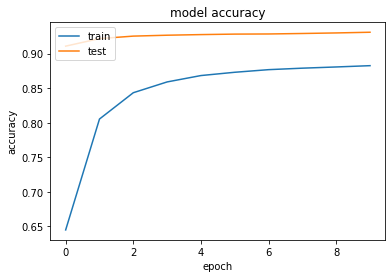

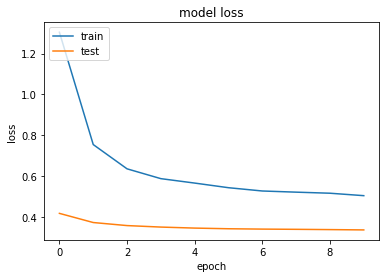

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mm_history.history['accuracy'])
plt.plot(mm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mm_history.history['loss'])
plt.plot(mm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()